In [1]:
class_names = dict((
(0, "Water"),
(1, "Snow/Ice"),
(2, "Open Space Developed"),
(3, "Low Intensity Developed"),
(4, "Medium Intensity Developed"),
(5, "High Intensity Developed"),
(6, "Barren Land"),
(7, "Deciduous Forest"),
(8, "Evergreen Forest"),
(9, "Mixed Forest"),
#(51, "Dwarf Scrub/Shrub - ALASKA"),
(10, "Scrub/Shrub"),
(11, "Grassland / Herbaceous"),
#(72, "Sedge / Herbaceous - ALASKA"),
#(73, "Lichen / Herbaceous - ALASKA"),
#(74, "Moss - ALASKA"),
(12, "Pasture/Hay"),
(13, "Cultivated Land"),
(14, "Woody Wetland"),
(15, "Emergent Herbaceous Wetlands"),
))


In [2]:
import rasterio
import numpy as np
import random
import math
import itertools
import os
import sys
import resnet as rs
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import classifier_utilities as cu
importlib.reload(cu)

Using TensorFlow backend.


<module 'classifier_utilities' from '/host/Desktop/cnn_dev/florence_mapping/classifier_utilities.py'>

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [4]:
label_dataset = rasterio.open('/deep_data/NLCD/NLCD_2016_Land_Cover_L48_20190424.img')

l8_image_paths = [
    '/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
    '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined.tif'
]

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined/aligned-LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/aligned-LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined/aligned-LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined/aligned-LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_SAR.tif',
]

dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-77.7672_35.00779_-75.79042_36.58923__4500X4262_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-78.07896_33.69485_-76.14021_35.27466__4500X4248_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-76.14021_34.71847_-74.14865_36.318__4500X4408_ShowLogo_False_tiff_depth=32f.tiff',
]


landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))
    
dem_datasets = []
for fp in dem_image_paths:
    dem_datasets.append(rasterio.open(fp))

In [5]:
pixels = cu.gen_balanced_pixel_locations(landsat_datasets[3:4], 70000, label_dataset)

100%|██████████| 1/1 [00:30<00:00, 30.15s/it]


In [7]:
buckets = cu.pixel_balance(pixels, landsat_datasets[3:4], label_dataset)

In [8]:
for i in range(len(class_names)):
    print(class_names[i])
    print(buckets[i])

Water
4375.0
Snow/Ice
0.0
Open Space Developed
4375.0
Low Intensity Developed
0.0
Medium Intensity Developed
4375.0
High Intensity Developed
0.0
Barren Land
4375.0
Deciduous Forest
4375.0
Evergreen Forest
4375.0
Mixed Forest
4375.0
Scrub/Shrub
4375.0
Grassland / Herbaceous
4375.0
Pasture/Hay
4375.0
Cultivated Land
4375.0
Woody Wetland
4375.0
Emergent Herbaceous Wetlands
4375.0


In [9]:
train_px, val_px, test_px = cu.train_val_test_split(pixels, 0.7, 0.8)

In [10]:
print(len(train_px))
print(len(val_px))
print(len(test_px))

39812
13650
6143


In [11]:
batch_size = 25
epochs = 200
num_classes = len(class_names)

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count + sentinel_datasets[0].count + dem_datasets[0].count - 1

input_shape = (img_bands,img_rows, img_cols)
print(input_shape)


(10, 64, 64)


In [12]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model

In [127]:
def make_model(in_shape):
    input_tensor = Input(shape = in_shape)
    conv_1 = SeparableConv2D(64, kernel_size=(2,2), activation='elu') (input_tensor)
    norm_1 = BatchNormalization() (conv_1)
    dropout_1 = Dropout(rate=0.5) (norm_1)
    pool = MaxPooling2D() (dropout_1)
    flatten = Flatten() (pool)
    dense = Dense(128, activation='elu') (flatten)
    output = Dense(num_classes,activation='softmax') (dense)
    model = Model(inputs=input_tensor, outputs=output)
    return model

In [13]:
model = rs.ResnetBuilder.build_resnet_50(input_shape,num_classes)
#model = make_model(input_shape)

In [14]:
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(generator=cu.tile_generator(landsat_datasets[3:4], sentinel_datasets[3:4], dem_datasets[3:4], label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=cu.tile_generator(landsat_datasets[3:4], sentinel_datasets[3:4], dem_datasets[3:4], label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/200
1592/1592 [==============================] - 475s 299ms/step - loss: 3.5276 - acc: 0.4075 - val_loss: 2.2817 - val_acc: 0.4021
Epoch 2/200
1592/1592 [==============================] - 457s 287ms/step - loss: 1.9417 - acc: 0.4827 - val_loss: 2.1955 - val_acc: 0.4065
Epoch 3/200
1397/1592 [=========================>....] - ETA: 47s - loss: 1.7170 - acc: 0.5364

In [154]:
predictions = model.predict_generator(generator=cu.tile_generator(landsat_datasets[3:4], sentinel_datasets[3:4], dem_datasets[3:4], 
        label_dataset, tile_side, tile_side, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)

eval_generator = cu.tile_generator(landsat_datasets[3:4], sentinel_datasets[4:], dem_datasets[4:], 
                                label_dataset, tile_side, tile_side, more_test_pixels, batch_size=1)

17624/17624 [==============================] - 2024s 115ms/step


In [143]:
buckets = cu.pixel_balance(test_px, landsat_datasets, label_dataset)

In [144]:
print(buckets)

[  34.    0.  296.    0.  150.    0.   43.  145. 1377.  160.  176.  160.
   72.  995. 1094.   17.]


In [155]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

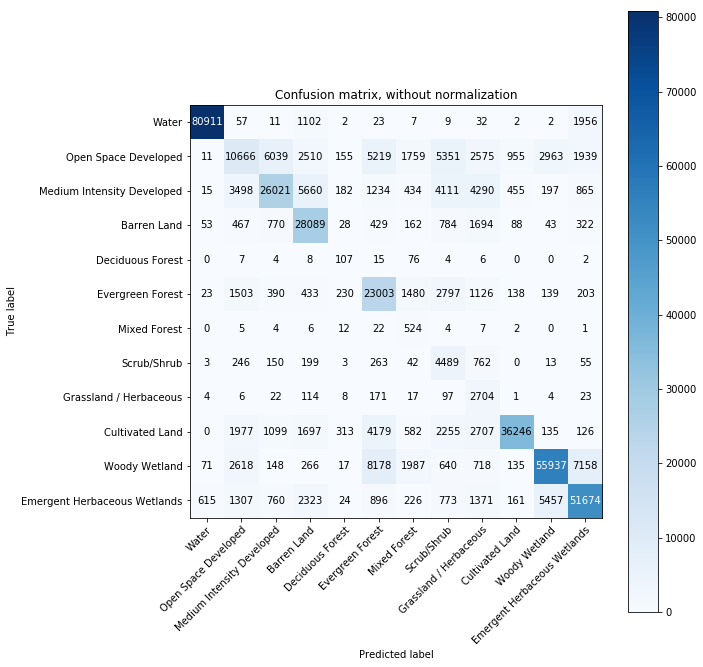

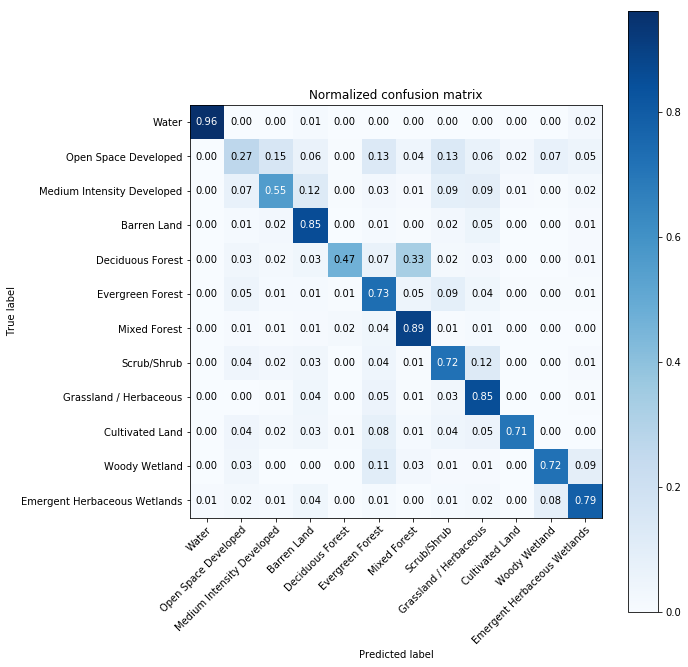

In [156]:
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [158]:
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1
print("ACCURACY")
print(count/len(label_index))

ACCURACY
0.7271243758511121
